# DSCI 100 Project: Predicting Subscriber Status







## Introduction

## Methods and Results

In [8]:
library(tidyverse)
library(repr) a
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [9]:
players <- read_csv("https://raw.githubusercontent.com/Jay7615/Project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/Jay7615/Project/refs/heads/main/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
⋮   ⋮            ⋮         ⋮                 ⋮  
194 0.0          Dylan     Prefer not to say 17 
195 2.3          Harlow    Male              17 
196 0.2          Ahmed     Other             NA

In [10]:
players <- players |>
  select(played_hours, Age, subscribe) |>
  rename(age = Age) |>
   mutate(subscriber_status = factor(subscribe, levels = c(FALSE, TRUE), labels = c("Non-subscriber", "Subscriber"))) |>
  select(-subscribe)

subscription_summary <- players |>
  group_by(subscriber_status) |>
  summarize(
    n = n(),
    percent = n/nrow(players),
    mean_age = mean(age, na.rm = TRUE),
    mean_hours = mean(played_hours),
    median_age = median(age, na.rm = TRUE),
    median_hours = median(played_hours),
    sd_age = sd(age, na.rm = TRUE),
    sd_hours = sd(played_hours),
    na_age = sum(is.na(age)),
    na_hours = sum(is.na(played_hours)),
  ) |>
  mutate(percent = percent(percent, accuracy = 0.1))  |>
    rename(amount = n)

players <- players |> drop_na(played_hours, age, subscriber_status)

subscription_summary

subscriber_status amount percent mean_age mean_hours median_age median_hours
1 Non-subscriber     52    26.5%   22.98077 0.5019231  21         0.0         
2 Subscriber        144    73.5%   19.61972 7.7756944  18         0.1         
  sd_age   sd_hours  na_age na_hours
1 8.166143  1.188258 0      0       
2 5.001748 32.892470 2      0

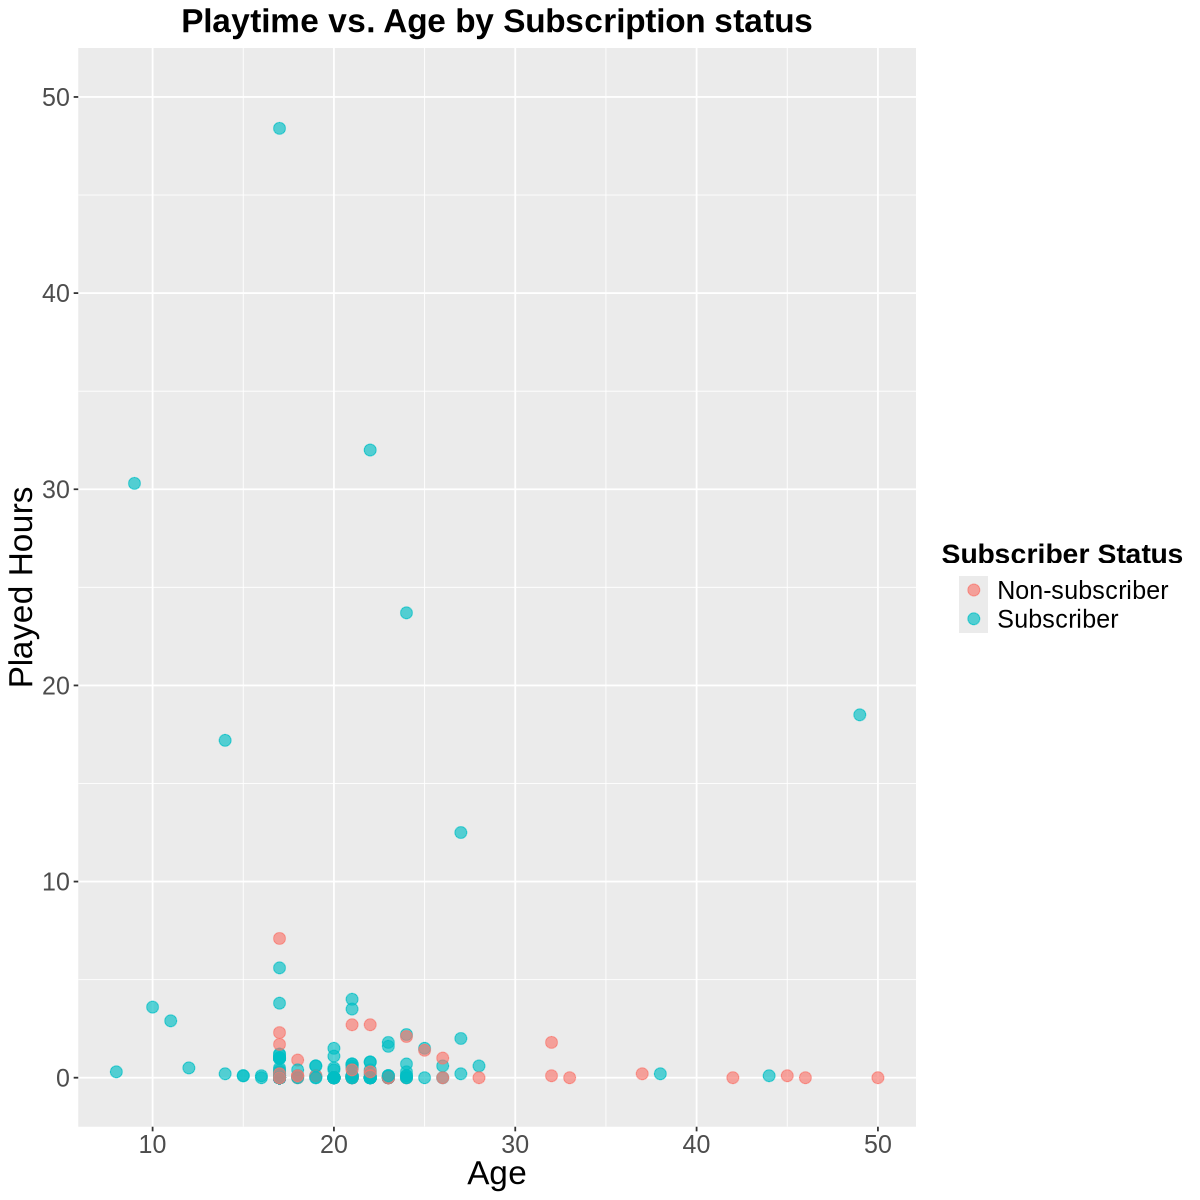

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(players, aes(x = age, y = played_hours, color = factor(subscriber_status))) +
  geom_point(alpha = 0.65, size = 3) +  
  labs(title = "Playtime vs. Age by Subscription status",
       x = "Age", y = "Played Hours", color = "Subscriber Status") +
  coord_cartesian(ylim = c(0, 50))+
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
       axis.text.x = element_text(size = 15),
       axis.text.y = element_text(size = 15),
       axis.title.x = element_text(size = 20),
       axis.title.y = element_text(size = 20),
       legend.title = element_text(face = "bold", size = 17, hjust = 0.5),
       legend.text = element_text(size = 15)
       )

In [12]:
players_split <- initial_split(players, prop = 0.75, strata = subscriber_status)
training_set <- training(players_split)
testing_set <- testing(players_split)

player_recipe <- recipe(subscriber_status ~ played_hours + age, 
                    data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = training_set)

validation_predicted <- predict(knn_fit, testing_set) |>
  bind_cols(testing_set)

acc <- validation_predicted |>
  metrics(truth = subscriber_status, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
acc

[1] 0.5510204

In [13]:
cv_folds_10 <- vfold_cv(training_set, v = 10, strata = subscriber_status)

vfold_metrics <- workflow() |>
                  add_recipe(player_recipe) |>
                  add_model(knn_spec) |>
                  fit_resamples(resamples = cv_folds_10) |>
                  collect_metrics()

vfold_metrics


.metric  .estimator mean      n  std_err    .config             
1 accuracy binary     0.5671062 10 0.04744493 Preprocessor1_Model1
2 roc_auc  binary     0.5602273 10 0.04830400 Preprocessor1_Model1

In [14]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cv_folds_10, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors .metric  .estimator mean      n  std_err    
1   1         accuracy binary     0.5221245 10 0.04390756 
2   2         accuracy binary     0.5231502 10 0.04154236 
3   3         accuracy binary     0.5671062 10 0.04744493 
⋮   ⋮         ⋮        ⋮          ⋮         ⋮  ⋮          
98   98       accuracy binary     0.7312088 10 0.005090213
99   99       accuracy binary     0.7312088 10 0.005090213
100 100       accuracy binary     0.7312088 10 0.005090213
    .config               
1   Preprocessor1_Model001
2   Preprocessor1_Model002
3   Preprocessor1_Model003
⋮   ⋮                     
98  Preprocessor1_Model098
99  Preprocessor1_Model099
100 Preprocessor1_Model100

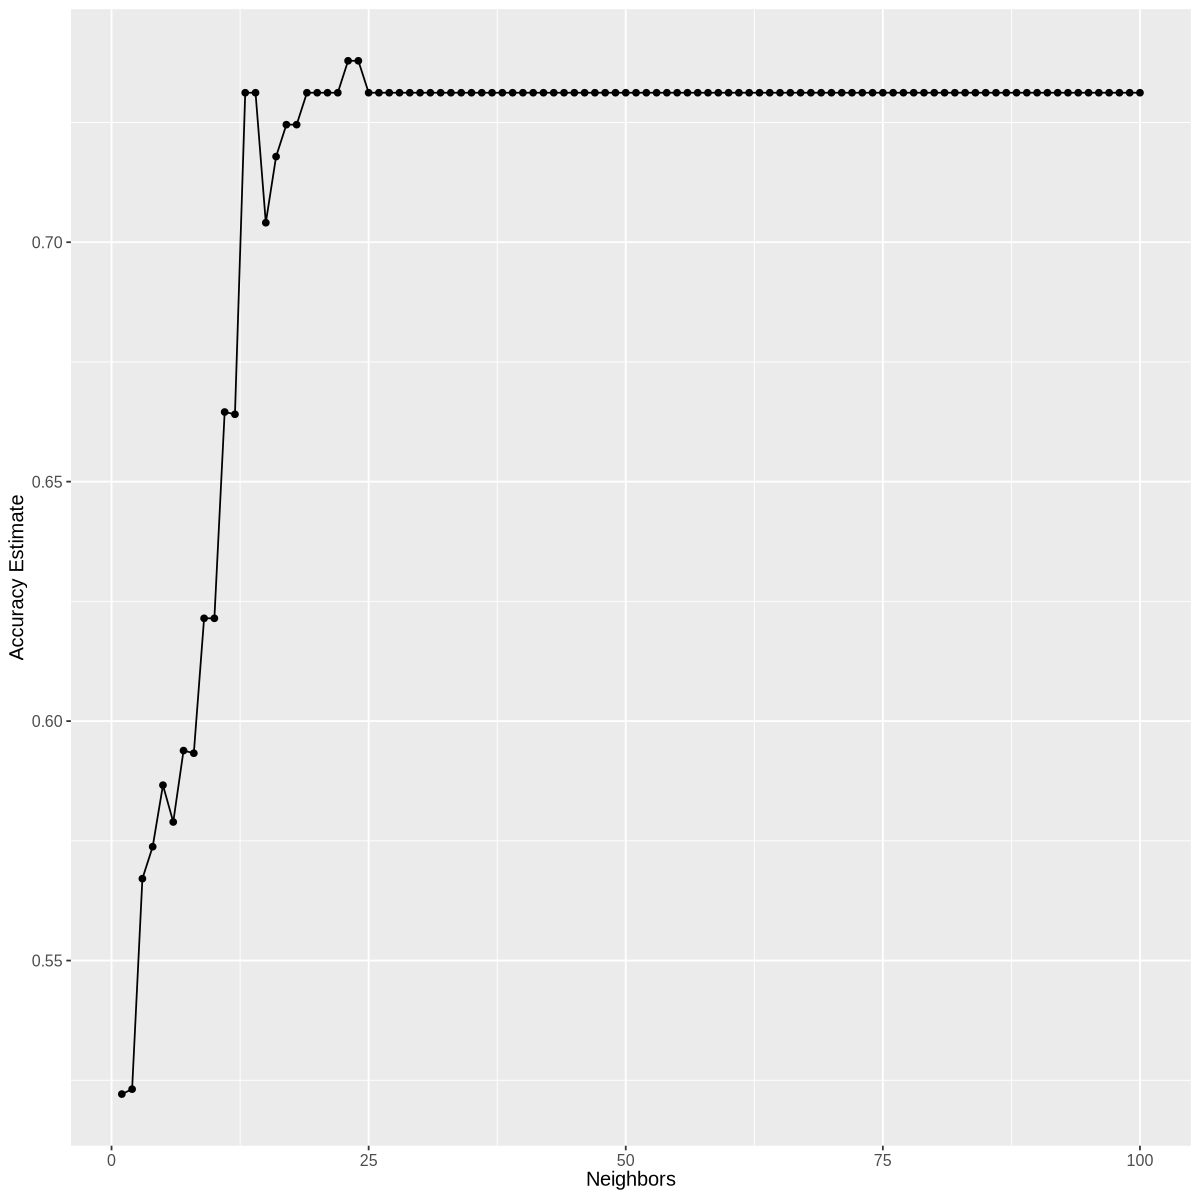

In [15]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [16]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 23

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = training_set)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 23

In [18]:
players_test_predictions <- predict(knn_fit, testing_set) |>
  bind_cols(testing_set)

  players_test_predictions |>
metrics(truth = subscriber_status, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
    precision(truth = subscriber_status, estimate = .pred_class, event_level="first")

players_test_predictions |>
    recall(truth = subscriber_status, estimate = .pred_class, event_level="first")

confusion <- players_test_predictions |>
             conf_mat(truth = subscriber_status, estimate = .pred_class)
confusion

.metric  .estimator .estimate
1 accuracy binary     0.755102

.metric   .estimator .estimate
1 precision binary     1

.metric .estimator .estimate 
1 recall  binary     0.07692308

                Truth
Prediction       Non-subscriber Subscriber
  Non-subscriber              1          0
  Subscriber                 12         36

In [32]:
knn_spec_real <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
  set_engine("kknn") |>
  set_mode("classification")

players_recipe_real <- recipe(subscriber_status ~ played_hours + age, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit_real <- workflow() |>
  add_recipe(players_recipe_real) |>
  add_model(knn_spec_real) |>
  fit(data = players)

new_observation <- tibble(played_hours = 1, age = 12)
prediction <- predict(knn_fit_real, new_observation)
prediction

.pred_class
1 Subscriber

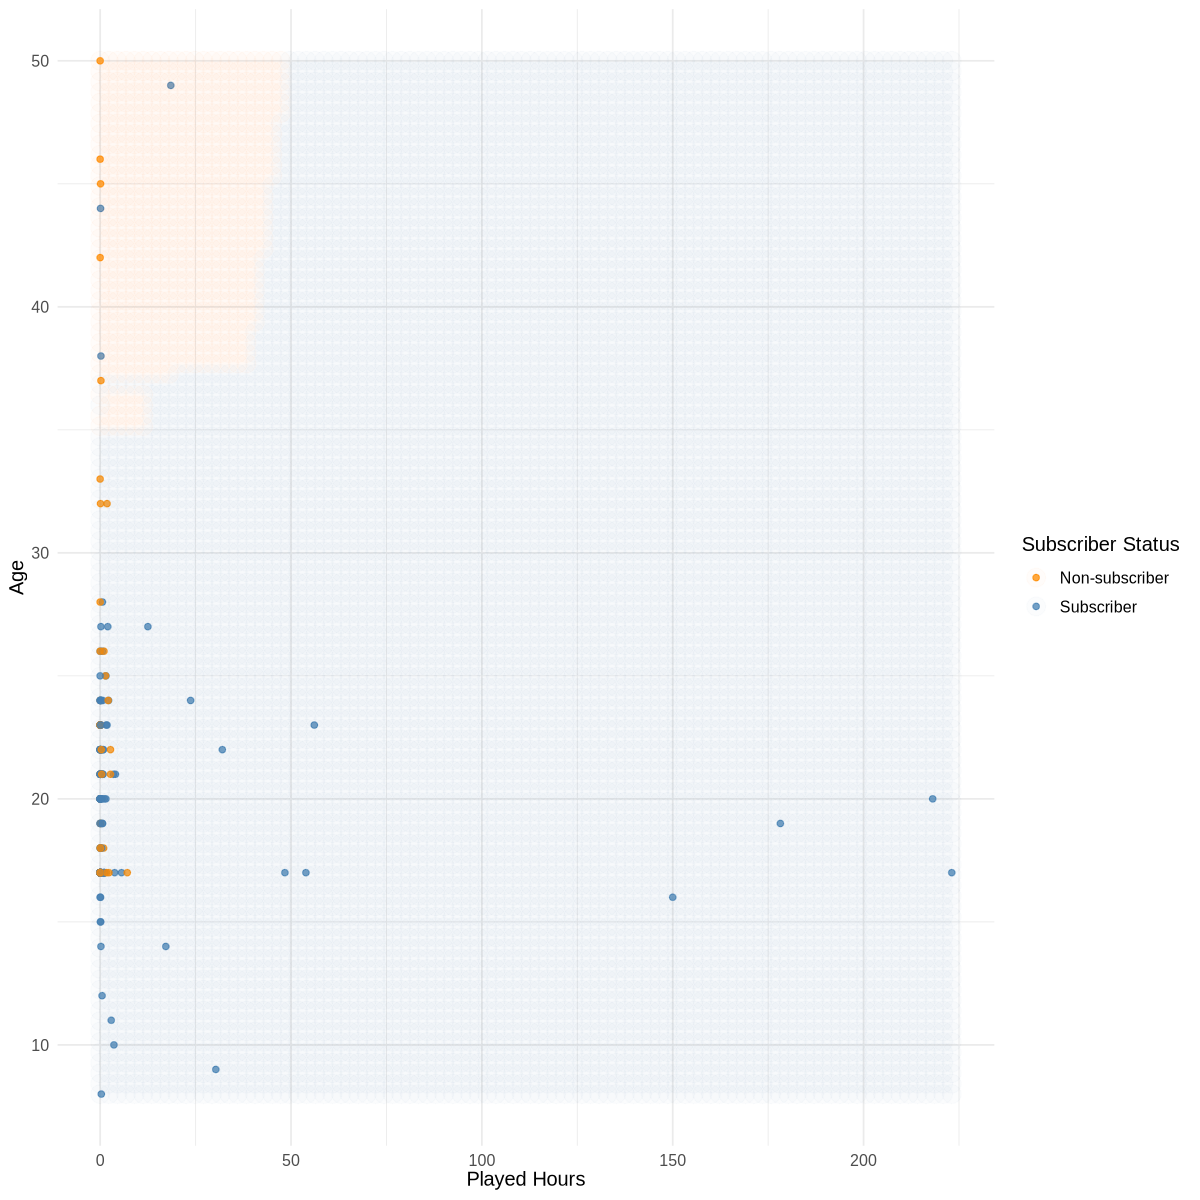

In [33]:
hours_grid <- seq(min(players$played_hours),
                  max(players$played_hours),
                  length.out = 100)

age_grid <- seq(min(players$age),
                max(players$age),
                length.out = 100)

grid_df <- as_tibble(expand.grid(played_hours = hours_grid,
                                  age = age_grid))

grid_predictions <- predict(knn_fit, grid_df)

prediction_table <- bind_cols(grid_df, grid_predictions) |>
  rename(Class = .pred_class)

ggplot() +
  geom_point(data = players,
             aes(x = played_hours,
                 y = age,
                 color = subscriber_status),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             aes(x = played_hours,
                 y = age,
                 color = Class),
             alpha = 0.02,
             size = 5) +
  labs(color = "Subscriber Status",
       x = "Played Hours",
       y = "Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme_minimal() +
  theme(text = element_text(size = 12))


## Discussion

## References